In [57]:
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd
import networkx as nx
import sqlite3
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import pandasql as pdsql


In [2]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_coor = pd.read_sql("select  geometry, lp.cable_id, lp.cable_name, cmlcc.merge_length as cable_length, cmlcc.merge_capacity as cable_capacity, cmlcc.merge_cost as cable_cost from landing_points lp left join cable_coor cc on lp.cable_id = cc.id left join cable_merge_length_capacity_cost cmlcc on lp.cable_id = cmlcc.cable_id group by geometry",con=con)
    landingPoint = pd.read_sql("select * from landing_points",con=con)

# cable_shap = gpd.GeoDataFrame(cable_coor, crs=4326)

In [3]:
cable_coor[cable_coor['cable_length'].isna() == True]

,geometry,cable_id,cable_name,cable_length,cable_capacity,cable_cost


In [4]:
cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")
# coor_list = cleaned_cable_coor.iloc[0].split(', (')
cleaned_cable_coor.iloc[2].split(', (')

index_cable_id = list(cable_coor.columns).index('cable_id')
index_cable_length = list(cable_coor.columns).index('cable_length')
index_cable_capacity = list(cable_coor.columns).index('cable_capacity')
index_cable_cost = list(cable_coor.columns).index('cable_cost')


data = pd.DataFrame()

for row in range(cleaned_cable_coor.shape[0]):
    coor_list = cleaned_cable_coor.iloc[row].split(', (')
    cable_id = cable_coor.iloc[row,index_cable_id]
    cable_length = cable_coor.iloc[row,index_cable_length]
    cable_capacity = cable_coor.iloc[row,index_cable_capacity]
    cable_cost = cable_coor.iloc[row,index_cable_cost]

    for x in coor_list:
        seg = pd.DataFrame()
        abc = x.split(', ')
        # print(abc)
        for y in abc:
            a = {'lon1': y.split(' ')[0], 'lat1': y.split(' ')[1], 'cable_id': cable_id, 'cable_length': cable_length, 'cable_capacity': cable_capacity,'cable_cost': cable_cost}
            seg = seg.append(a,ignore_index=True)
        seg["lon1"] = seg["lon1"].astype("float64")
        seg["lat1"] = seg["lat1"].astype("float64")
        seg['lon2'] = seg['lon1'].shift()
        seg['lat2'] = seg['lat1'].shift()
        data = data.append(seg,ignore_index=True)
data

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_1063/2595705227.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")


,lon1,lat1,cable_id,cable_length,cable_capacity,cable_cost,lon2,lat2
0,-0.134426,50.828479,crosschannel-fibre,149.0,2400.000000,3.875,NaN,NaN
1,0.000074,50.597677,crosschannel-fibre,149.0,2400.000000,3.875,-0.134426,50.828479
2,0.450074,50.022920,crosschannel-fibre,149.0,2400.000000,3.875,0.000074,50.597677
3,0.797774,49.877307,crosschannel-fibre,149.0,2400.000000,3.875,0.450074,50.022920
4,-0.204316,5.558286,glo-1,9800.0,2.500000,260.000,NaN,NaN
...,...,...,...,...,...,...,...,...
11075,101.250003,2.425987,damai-cable-system,575.0,44.384991,14.375,100.575003,2.705081
11076,101.758252,2.143087,damai-cable-system,575.0,44.384991,14.375,101.250003,2.425987
11077,101.870752,1.976445,damai-cable-system,575.0,44.384991,14.375,101.758252,2.143087
11078,101.728127,1.805588,damai-cable-system,575.0,44.384991,14.375,101.870752,1.976445


In [5]:
# data['lon2'] = data['lon1'].shift()
# data['lat2'] = data['lat1'].shift()
# data["lon1"] = data["lon1"].astype("float64")
# data["lat1"] = data["lat1"].astype("float64")

In [6]:
# cable_coor.iloc[0,1]
# cable_coor.iloc[2,1]

In [7]:
# data.dropna()
gdf = gpd.GeoDataFrame(data)
    # data,geometry=gpd.points_from_xy(data.lon1, data.lat1), crs=4326)
gdf['fr_point'] = gpd.points_from_xy(x=gdf['lon1'],y=gdf['lat1'])
gdf['to_point'] = gpd.points_from_xy(x=gdf['lon2'],y=gdf['lat2'])
gdf['fr_id'] = round((round(gdf['lon1'],5) + round(gdf['lat1'],5))*100000,0)
gdf['to_id'] = round((round(gdf['lon2'],5) + round(gdf['lat2'],5))*100000,0)
gdf['distance_from_previous'] = gdf['fr_point'].distance(gdf['to_point'])
gdf['total_distance'] = gdf.groupby('cable_id')['distance_from_previous'].transform('sum')
gdf['length_from_previous'] = gdf['cable_length'] / gdf['total_distance'] * gdf['distance_from_previous']
gdf['segment_cost'] = gdf['cable_cost']/gdf['cable_length'] * gdf['length_from_previous']
gdf['inverse_capacity'] = 1/gdf['cable_capacity']

In [8]:
gdf[gdf['cable_length'].isna()==True]

,lon1,lat1,cable_id,cable_length,cable_capacity,cable_cost,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,total_distance,length_from_previous,segment_cost,inverse_capacity


In [9]:
gdf = gdf[gdf['to_id'].isna() == False].iloc[1::,]
gdf['line'] = gdf.apply(lambda row: LineString([row['fr_point'], row['to_point']]), axis=1) #Create a linestring column


In [10]:
gdf = gpd.GeoDataFrame(gdf, geometry=gdf['line'])
worldMap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Text(0.5, 1.0, 'Low level data description')

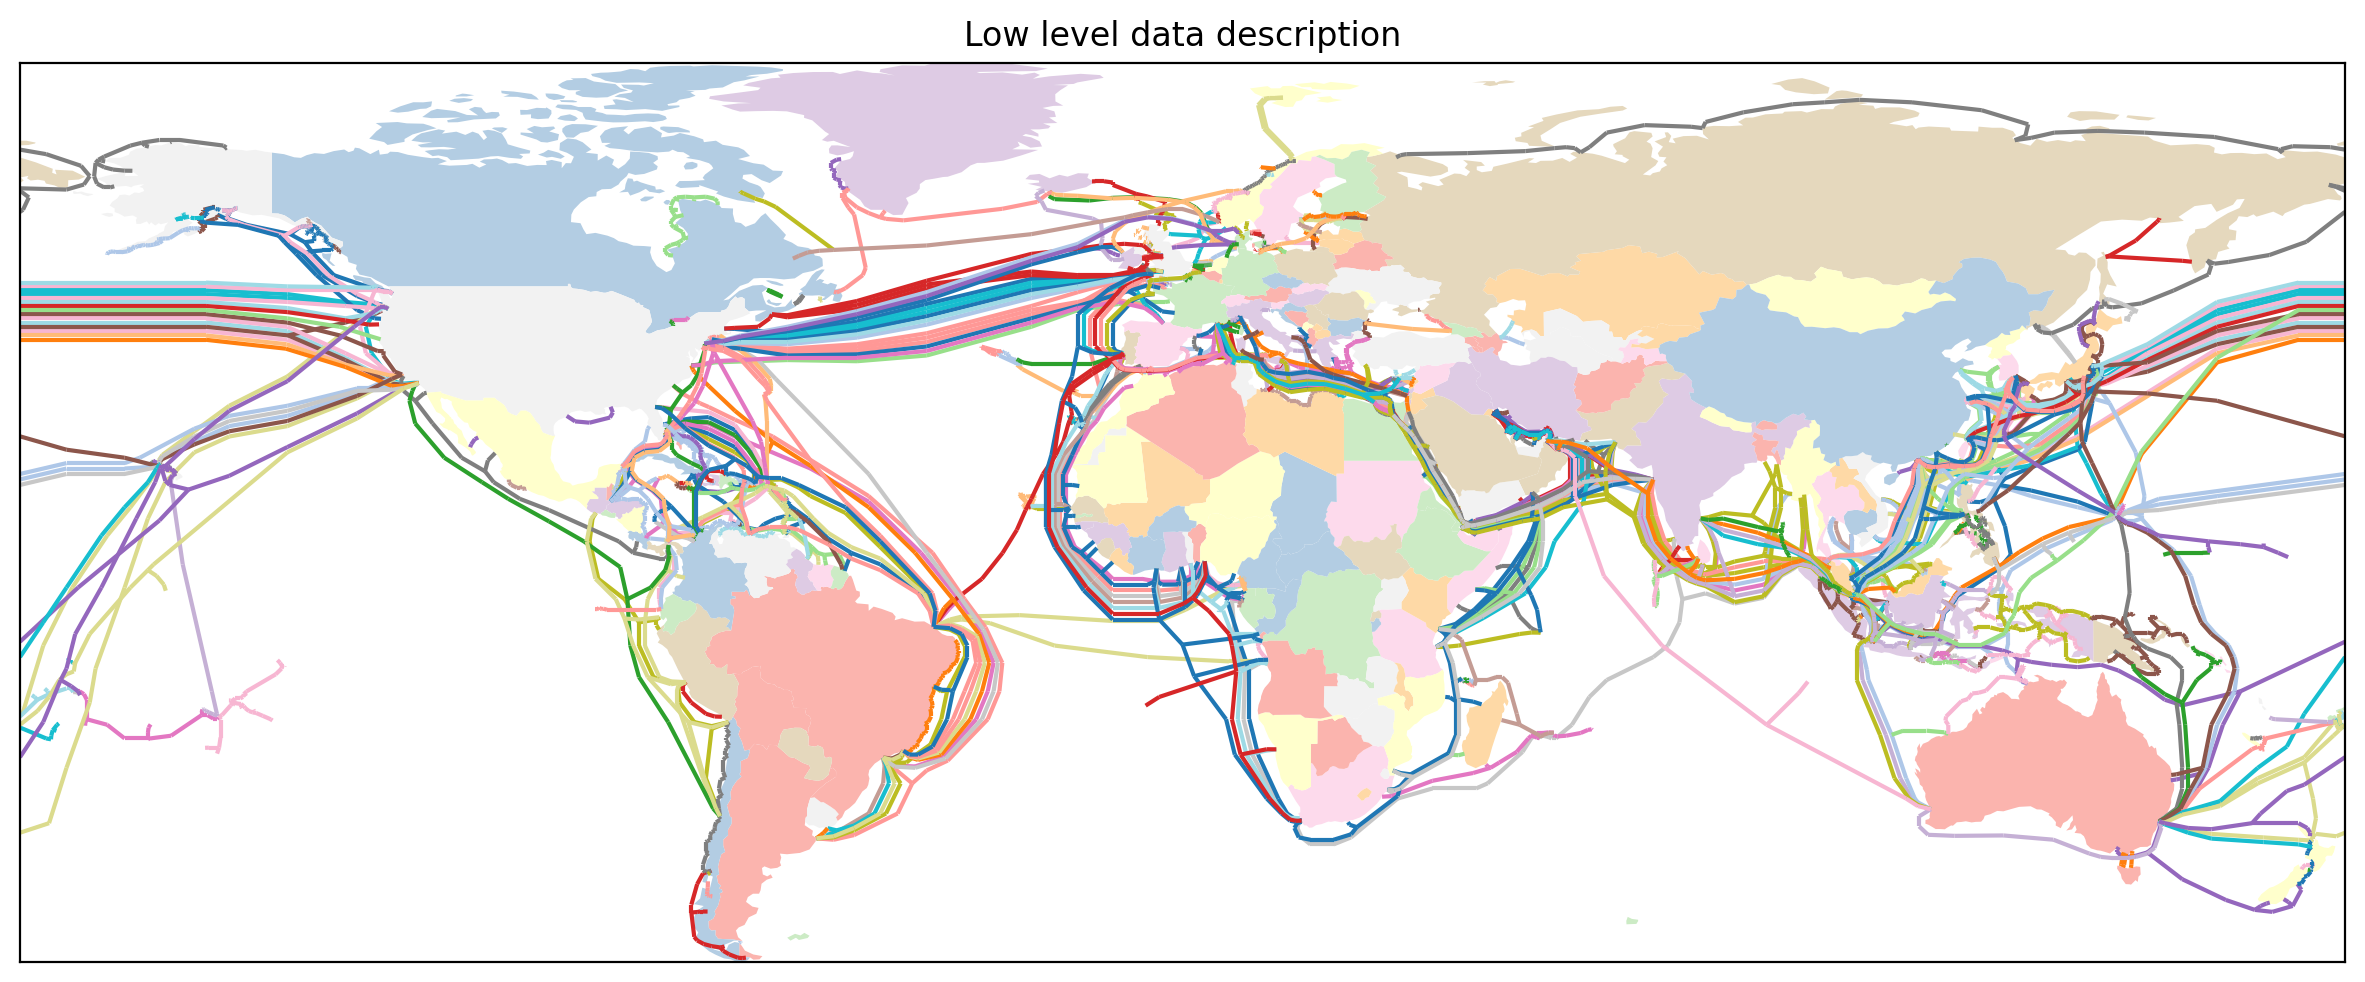

In [11]:
worldMap=worldMap[worldMap['continent'] != 'Antarctica']
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column='name', ax=ax, legend=False,cmap='Pastel1',aspect=1,legend_kwds={'loc': 'lower left'})
gdf.plot(column='cable_id',ax=ax, cmap='tab20')

ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.title("Low level data description")

In [12]:
# gdf.drop('geometry', axis=1,inplace=True)
# gdf.to_file("/Users/dijiongyuequ/Downloads/cable_distance.geojson", driver='GeoJSON')
# gdf

In [13]:
gdf = gdf.reset_index( )


In [14]:

gdf.query('lon1 < 121.4726 and lon1 > 121.4725')

,index,lon1,lat1,cable_id,cable_length,cable_capacity,cable_cost,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,total_distance,length_from_previous,segment_cost,inverse_capacity,line,geometry
4178,4776,121.472587,31.247574,seamewe-3,39000.0,0.139855,1007.78,122.174988,31.238657,POINT (121.47259 31.24757),POINT (122.17499 31.23866),15272016.0,15341365.0,0.702457,355.922922,76.971256,1.988977,7.150281,LINESTRING (121.47258699999978 31.247573900928...,"LINESTRING (121.47259 31.24757, 122.17499 31.2..."


In [15]:
G = nx.from_pandas_edgelist(gdf, 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous','segment_cost','inverse_capacity'], create_using=nx.Graph)


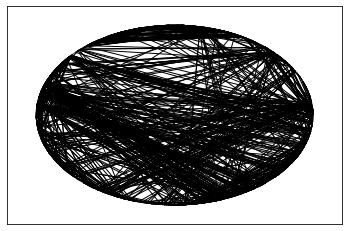

In [16]:
nx.draw_networkx_edges(G, pos=nx.circular_layout(G))


In [17]:
path = nx.shortest_path(G,6181995, 4629267, weight = 'length_from_previous')

# def getPath(path, road):
#     pathroad = pd.DataFrame()
#     for i in range(5):
#         # len(path.keys())-1
#         node1 = path[list (path.keys())[i]]
#         print(node1)
#         node2 = path[list (path.keys())[i+1]]
#         print(node2)
#         r = road[(road['fr_id'] == node1) & (road['to_id'] == node2)]
#         pathroad = pathroad.append(r)
#     return pathroad

def getPath(path, road):
    pathroad = pd.DataFrame()
    for i in range(len(path)-1):
        # len(path.keys())-1
        node1 = path[i]
        node2 = path[i+1]
        # fr_id and to_id might be in opposite order
        r = road[ ((road['fr_id'] == node1) & (road['to_id'] == node2)) | (road['fr_id'] == node2) & (road['to_id'] == node1) ]
        pathroad = pathroad.append(r)
    return pathroad

In [18]:
# path1 = nx.shortest_path(G,6181995, 10373031, weight = 'length')
# path2 = nx.shortest_path(G,2943486, 10373031, weight = 'length')


# set(path1).difference(set(path2))

In [94]:
def shortest_path_node_df(path_road):

    temp1 = path_road[ (round(path_road['lon1'],4).isin(round(landingPoint['landingPoint_longitude'],4)) & round(path_road['lat1'],4).isin(round(landingPoint['landingPoint_latitude'],4))) | (round(path_road['lon2'],4).isin(round(landingPoint['landingPoint_longitude'],4)) & round(path_road['lat2'],4).isin(round(landingPoint['landingPoint_latitude'],4)))]
    temp1['lon1'] = round(path_road['lon1'],4)
    temp1['lat1'] = round(path_road['lat1'],4)

    temp2 = landingPoint.copy()
    temp2['landingPoint_longitude'] = round(landingPoint['landingPoint_longitude'],4)
    temp2['landingPoint_latitude'] = round(landingPoint['landingPoint_latitude'],4)

    return pd.merge(temp1,temp2,how='inner', left_on=['lon1','lat1','cable_id'], right_on=['landingPoint_longitude','landingPoint_latitude','cable_id'])


In [100]:
def shortest_path_analysis_summary(path_road):

    # Error, this result also include the other cables in the same landingpoint
    shortest_path_edge = path_road [ round(path_road['lon1'],4).isin(round(landingPoint['landingPoint_longitude'],4)) & round(path_road['lat1'],4).isin(round(landingPoint['landingPoint_latitude'],4))]
    print(f'By passed { shortest_path_edge.shape[0] } landing point')

    shortest_path_landingPoints = shortest_path_node_df(path_road)['landingPoint_name']
    g = lambda x: x.split(',')[0]
    print(f'Landing stations are {[g(x) for x in list (shortest_path_landingPoints)]}')

    shortest_path_landingCountries = shortest_path_node_df(path_road)['landingPoint_country']
    print(f'Landing countries are {[g(x) for x in list (shortest_path_landingCountries)]}')

    shortest_path_length = path_road['length_from_previous'].sum()
    print(f'This route passed { shortest_path_length } km')

    shortest_path_latency = shortest_path_length/200000
    print(f'The estimated latency for this route is { shortest_path_latency } s')

    shortest_path_cost = path_road['segment_cost'].sum()
    print(f'With estimated cost of { shortest_path_cost } million US $')

    shortest_path_capacity = path_road['cable_capacity'].min()
    print(f'Max capacity of { shortest_path_capacity }Tb/s')


By passed 6 landing point
Landing stations are ['Shanghai', 'Tseung Kwan O', 'Tseung Kwan O', 'Satun', 'Mumbai', 'Bude']
Landing countries are ['China', 'China', 'China', 'Thailand', 'India', 'United Kingdom']
This route passed 21235.40358139771 km
The estimated latency for this route is 0.10617701790698855 s
With estimated cost of 713.397616189231 million US $
Max capacity of 0.13985463762945624Tb/s


/opt/homebrew/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/homebrew/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


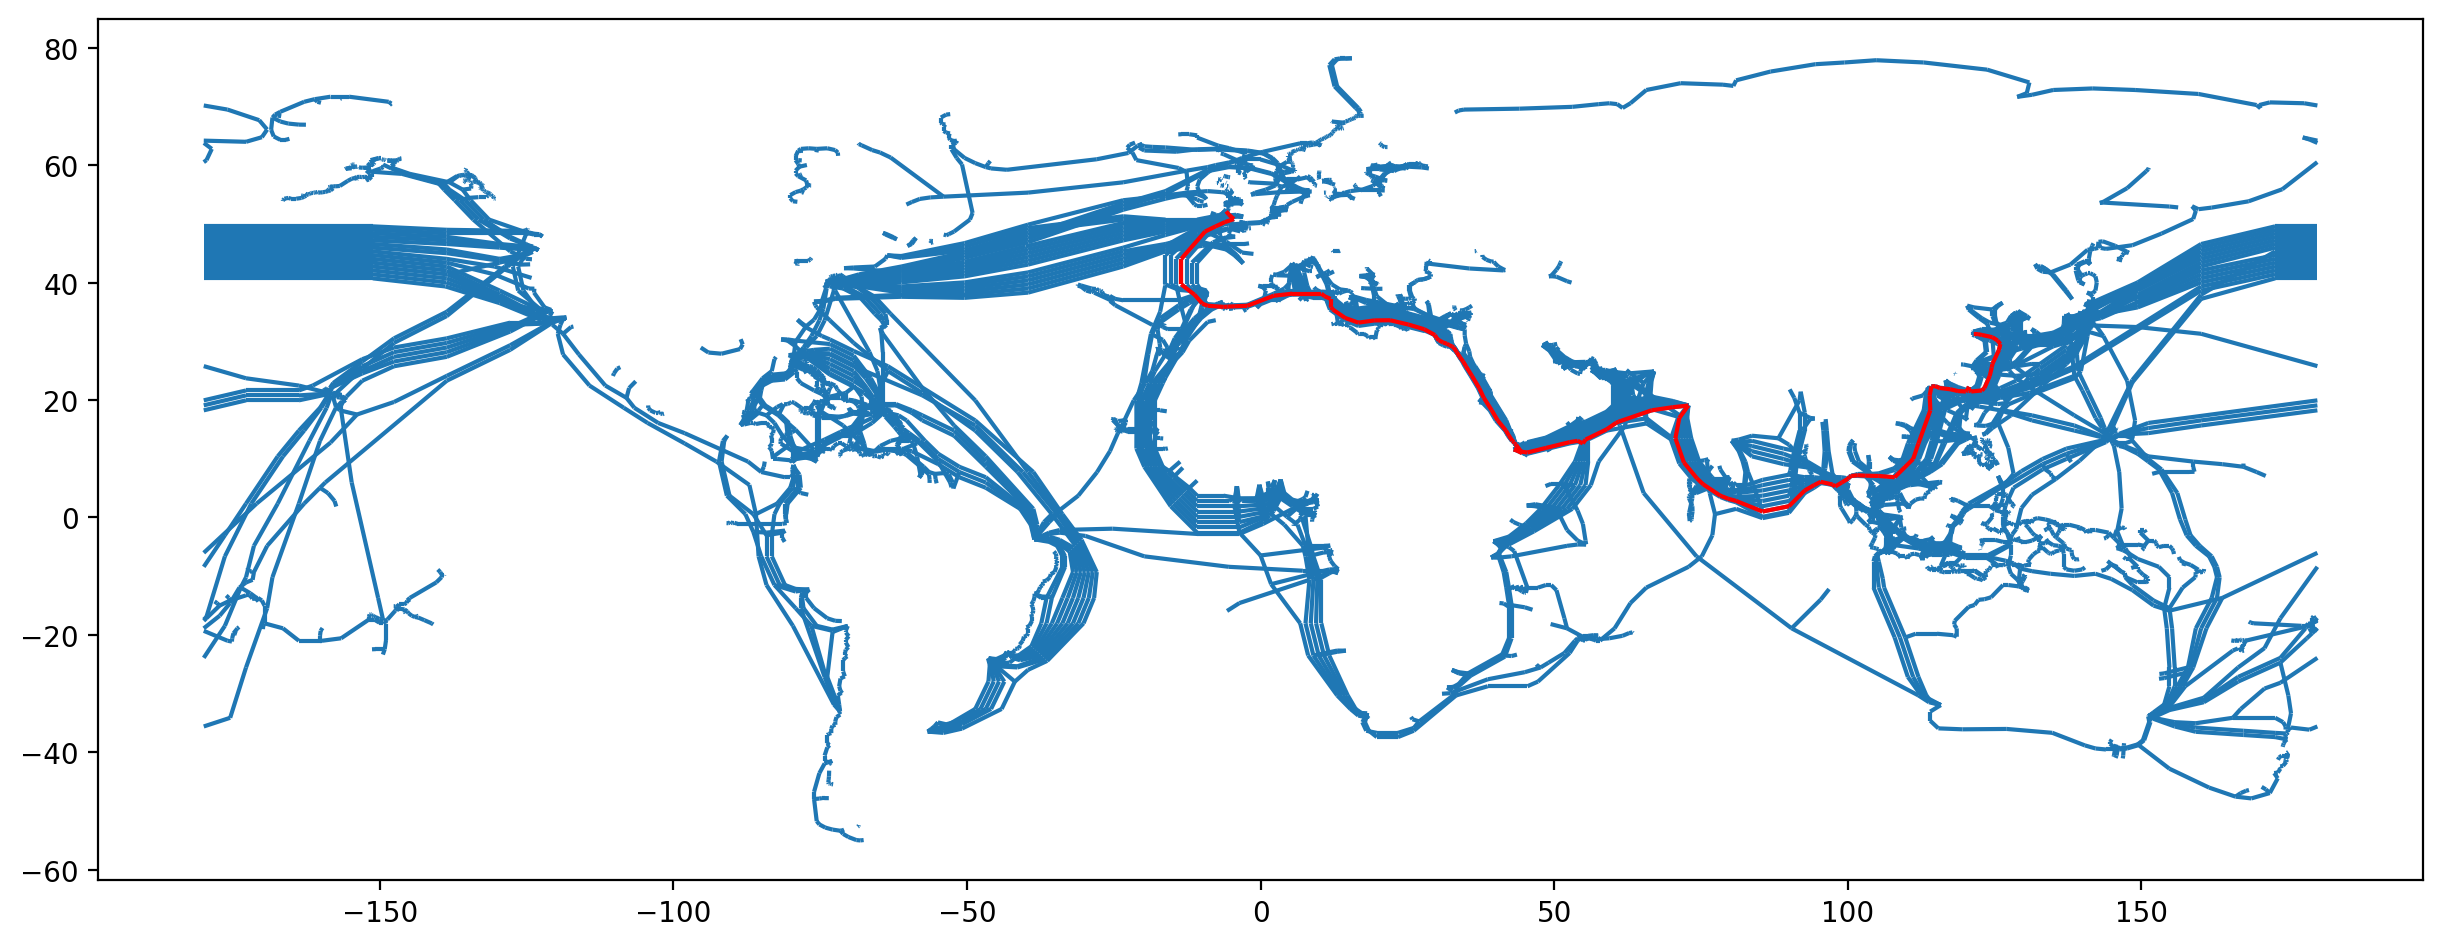

In [101]:
# shortest path in distance
path = nx.shortest_path(G,15272016, 4629267, weight = 'length_from_previous')


fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)

path_road = getPath(path, gdf)
gdf.plot(ax=ax)
path_road.plot(ax = ax, color='red')

shortest_path_analysis_summary(path_road)

By passed 3 landing point
Landing stations are ['Shanghai', 'Mumbai', 'Bude']
Landing countries are ['China', 'India', 'United Kingdom']
This route passed 22437.98093462744 km
The estimated latency for this route is 0.1121899046731372 s
With estimated cost of 564.6272222038509 million US $
Max capacity of 0.03Tb/s


/opt/homebrew/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/homebrew/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


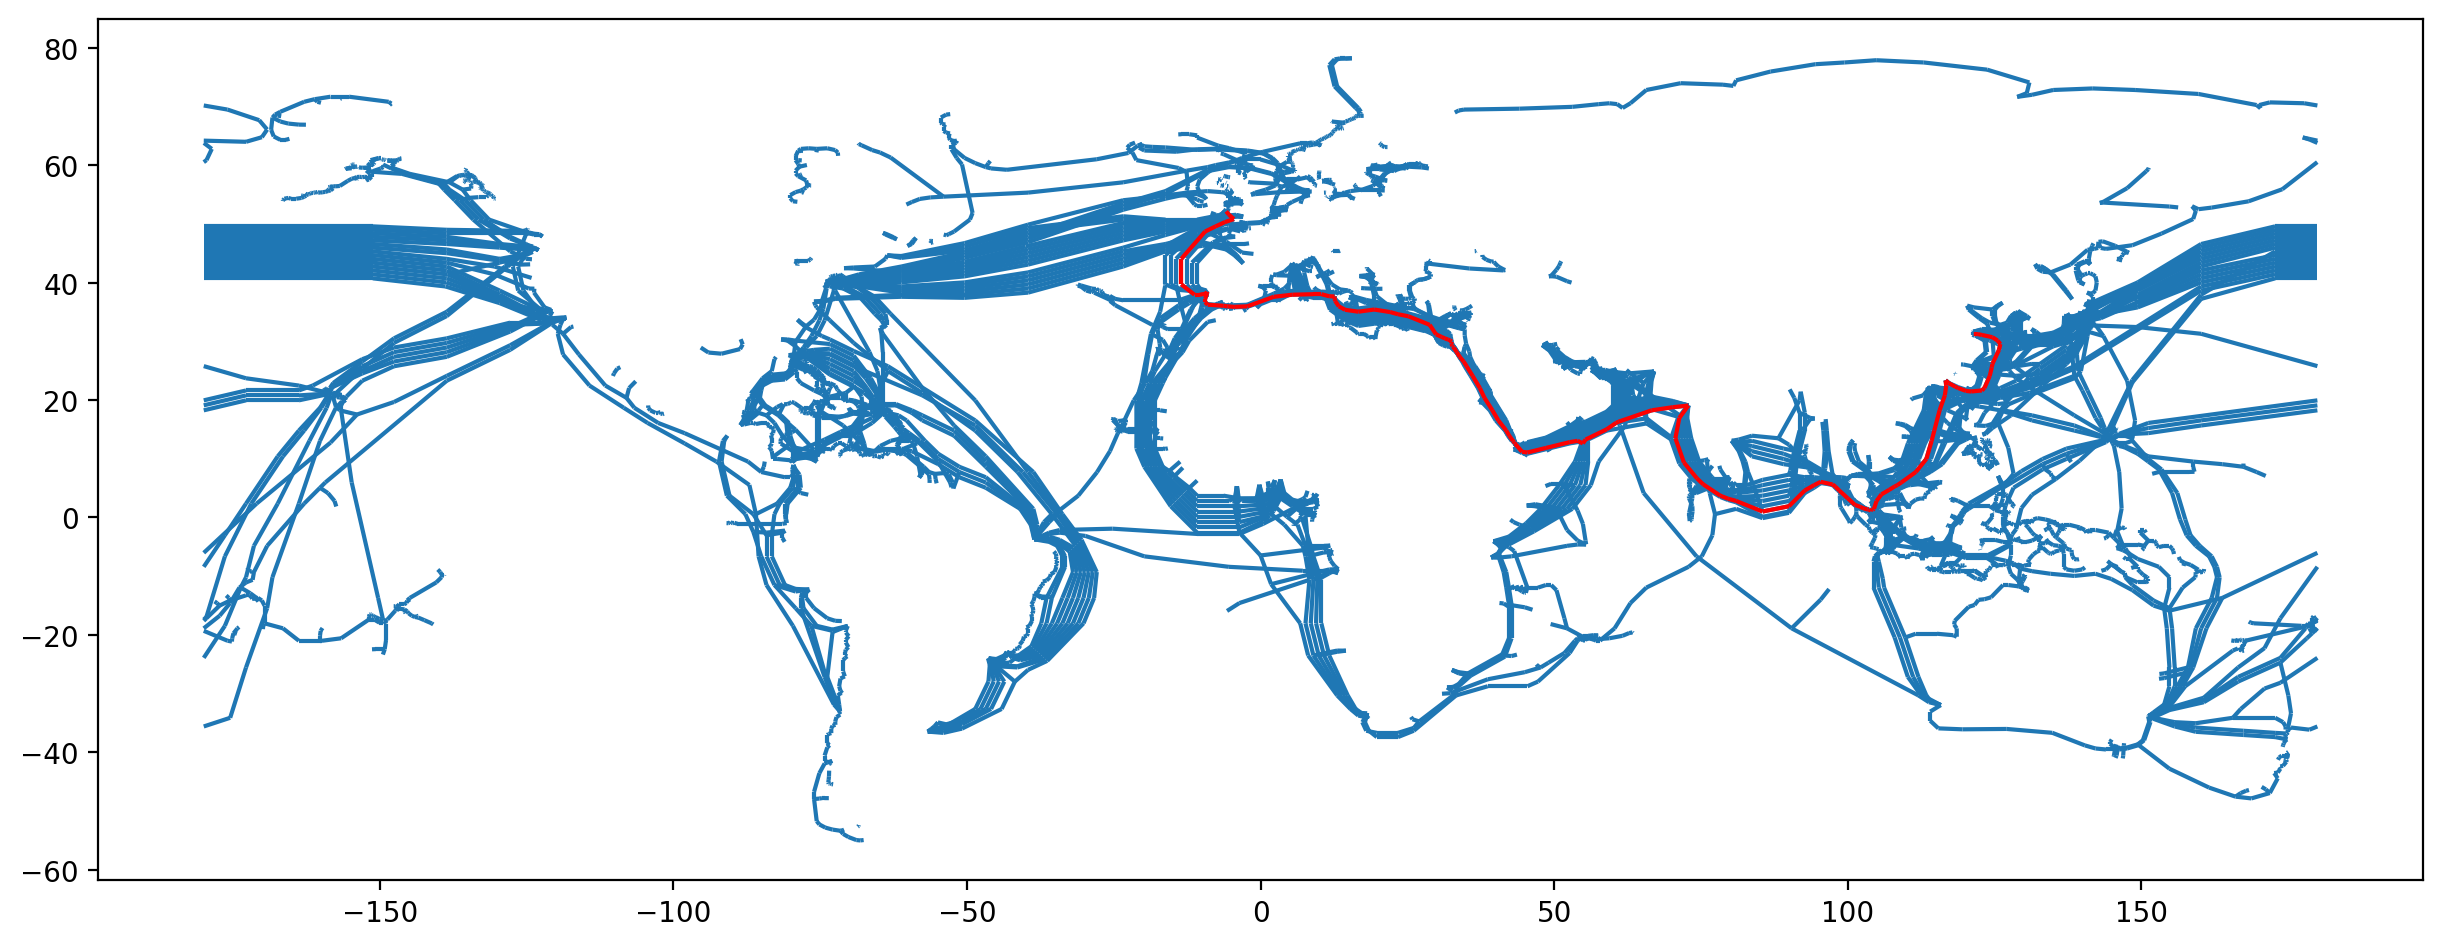

In [102]:
path = nx.shortest_path(G,15272016, 4629267, weight = 'segment_cost')


fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)

path_road = getPath(path, gdf)
gdf.plot(ax=ax)
path_road.plot(ax = ax, color='red')

shortest_path_analysis_summary(path_road)

By passed 4 landing point
Landing stations are ['Shanghai', 'Mumbai', 'Cape Town', 'Bude']
Landing countries are ['China', 'India', 'South Africa', 'United Kingdom']
This route passed 36556.14586494072 km
The estimated latency for this route is 0.1827807293247036 s
With estimated cost of 961.4102100940016 million US $
Max capacity of 0.13985463762945624Tb/s


/opt/homebrew/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/homebrew/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


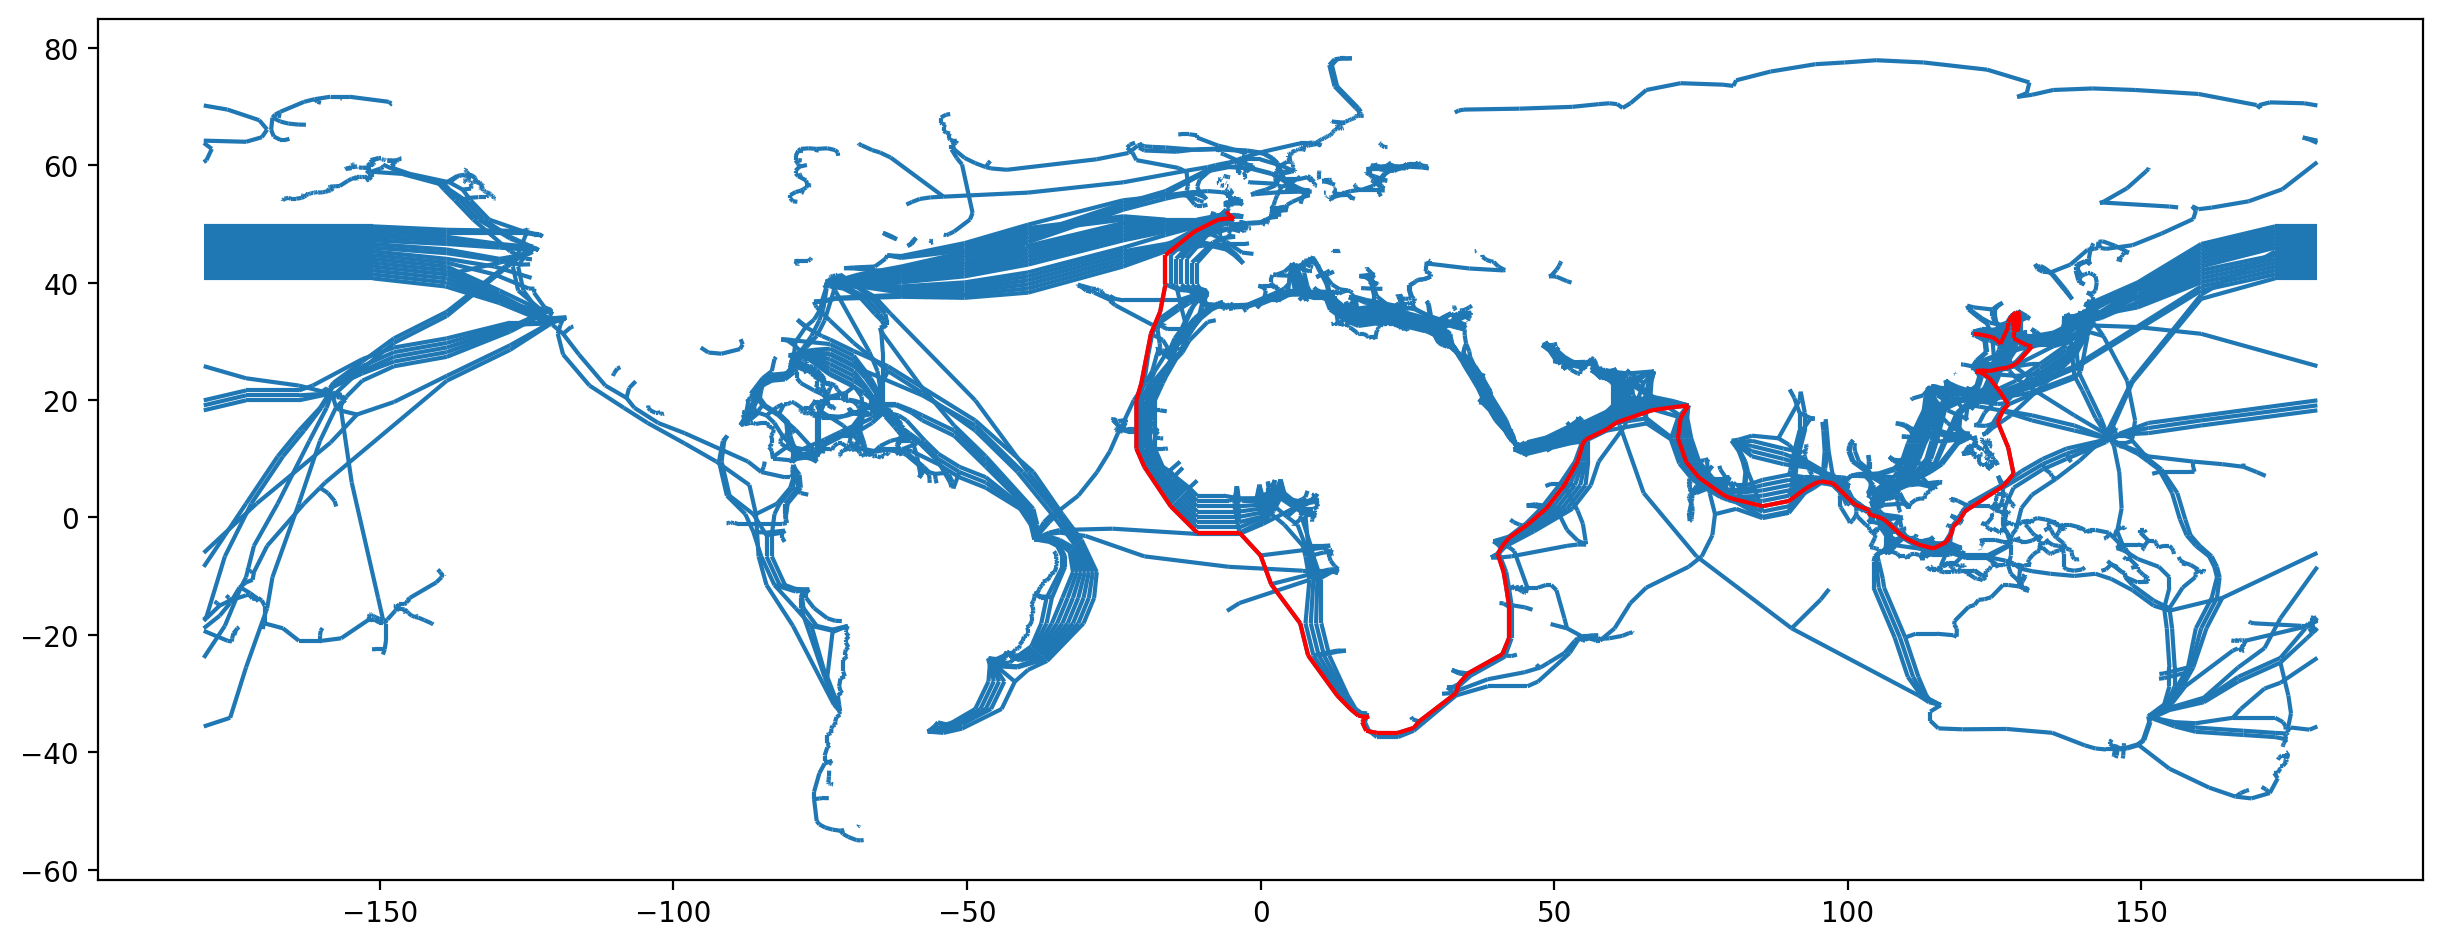

In [103]:
path = nx.shortest_path(G,15272016, 4629267, weight = 'inverse_capacity')


fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)

path_road = getPath(path, gdf)
gdf.plot(ax=ax)
path_road.plot(ax = ax, color='red')

shortest_path_analysis_summary(path_road)

In [23]:
# efficiency: https://en.wikipedia.org/wiki/Efficiency_(network_science)
nx.algorithms.efficiency(G,15272016, 4629267)


0.00980392156862745

In [24]:
path_road.head()

,index,lon1,lat1,cable_id,cable_length,cable_capacity,cable_cost,lon2,lat2,fr_point,to_point,fr_id,to_id,distance_from_previous,total_distance,length_from_previous,segment_cost,inverse_capacity,line,geometry
4178,4776,121.472587,31.247574,seamewe-3,39000.0,0.139855,1007.78,122.174988,31.238657,POINT (121.47259 31.24757),POINT (122.17499 31.23866),15272016.0,15341365.0,0.702457,355.922922,76.971256,1.988977,7.150281,LINESTRING (121.47258699999978 31.247573900928...,"LINESTRING (121.47259 31.24757, 122.17499 31.2..."
4177,4775,122.174988,31.238657,seamewe-3,39000.0,0.139855,1007.78,122.849987,31.094263,POINT (122.17499 31.23866),POINT (122.84999 31.09426),15341365.0,15394425.0,0.690271,355.922922,75.635939,1.954471,7.150281,LINESTRING (122.17498768603221 31.238656526340...,"LINESTRING (122.17499 31.23866, 122.84999 31.0..."
4176,4774,122.849987,31.094263,seamewe-3,39000.0,0.139855,1007.78,124.649986,30.708140,POINT (122.84999 31.09426),POINT (124.64999 30.70814),15394425.0,15535813.0,1.840947,355.922922,201.720465,5.212560,7.150281,LINESTRING (122.84998720785634 31.094262827639...,"LINESTRING (122.84999 31.09426, 124.64999 30.7..."
4175,4773,124.649986,30.708140,seamewe-3,39000.0,0.139855,1007.78,125.549985,30.126050,POINT (124.64999 30.70814),POINT (125.54999 30.12605),15535813.0,15567604.0,1.071834,355.922922,117.445428,3.034850,7.150281,LINESTRING (124.64998593272028 30.708139993541...,"LINESTRING (124.64999 30.70814, 125.54999 30.1..."
4174,4772,125.549985,30.126050,seamewe-3,39000.0,0.139855,1007.78,125.999985,29.540508,POINT (125.54999 30.12605),POINT (125.99998 29.54051),15567604.0,15554049.0,0.738484,355.922922,80.918905,2.090986,7.150281,LINESTRING (125.54998529515225 30.126049846722...,"LINESTRING (125.54999 30.12605, 125.99998 29.5..."


In [25]:
nx.shortest_path_length(G,15272016, 10373031, weight = 'length_from_previous')


5536.345022164888

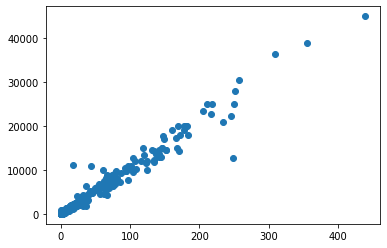

In [26]:
# path = nx.shortest_path(G,6158154, 4629267)


# fig     = plt.figure(figsize=(15,10),dpi = 200)
# ax      = plt.subplot(111)

# path_road = getPath(path, gdf)
# gdf.plot(ax=ax)
# path_road.plot(ax = ax, color='red')


with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    temp = pd.read_sql("select sum(distance_from_previous) as cable_dis, cd.cable_id, cmlcc.merge_length as cable_length from cable_distance cd left join cable_merge_length_capacity_cost cmlcc on cd.cable_id = cmlcc.cable_id group by cd.cable_id",con=con)

plt.scatter(x= 'cable_dis', y='cable_length', data=temp)

<AxesSubplot:>

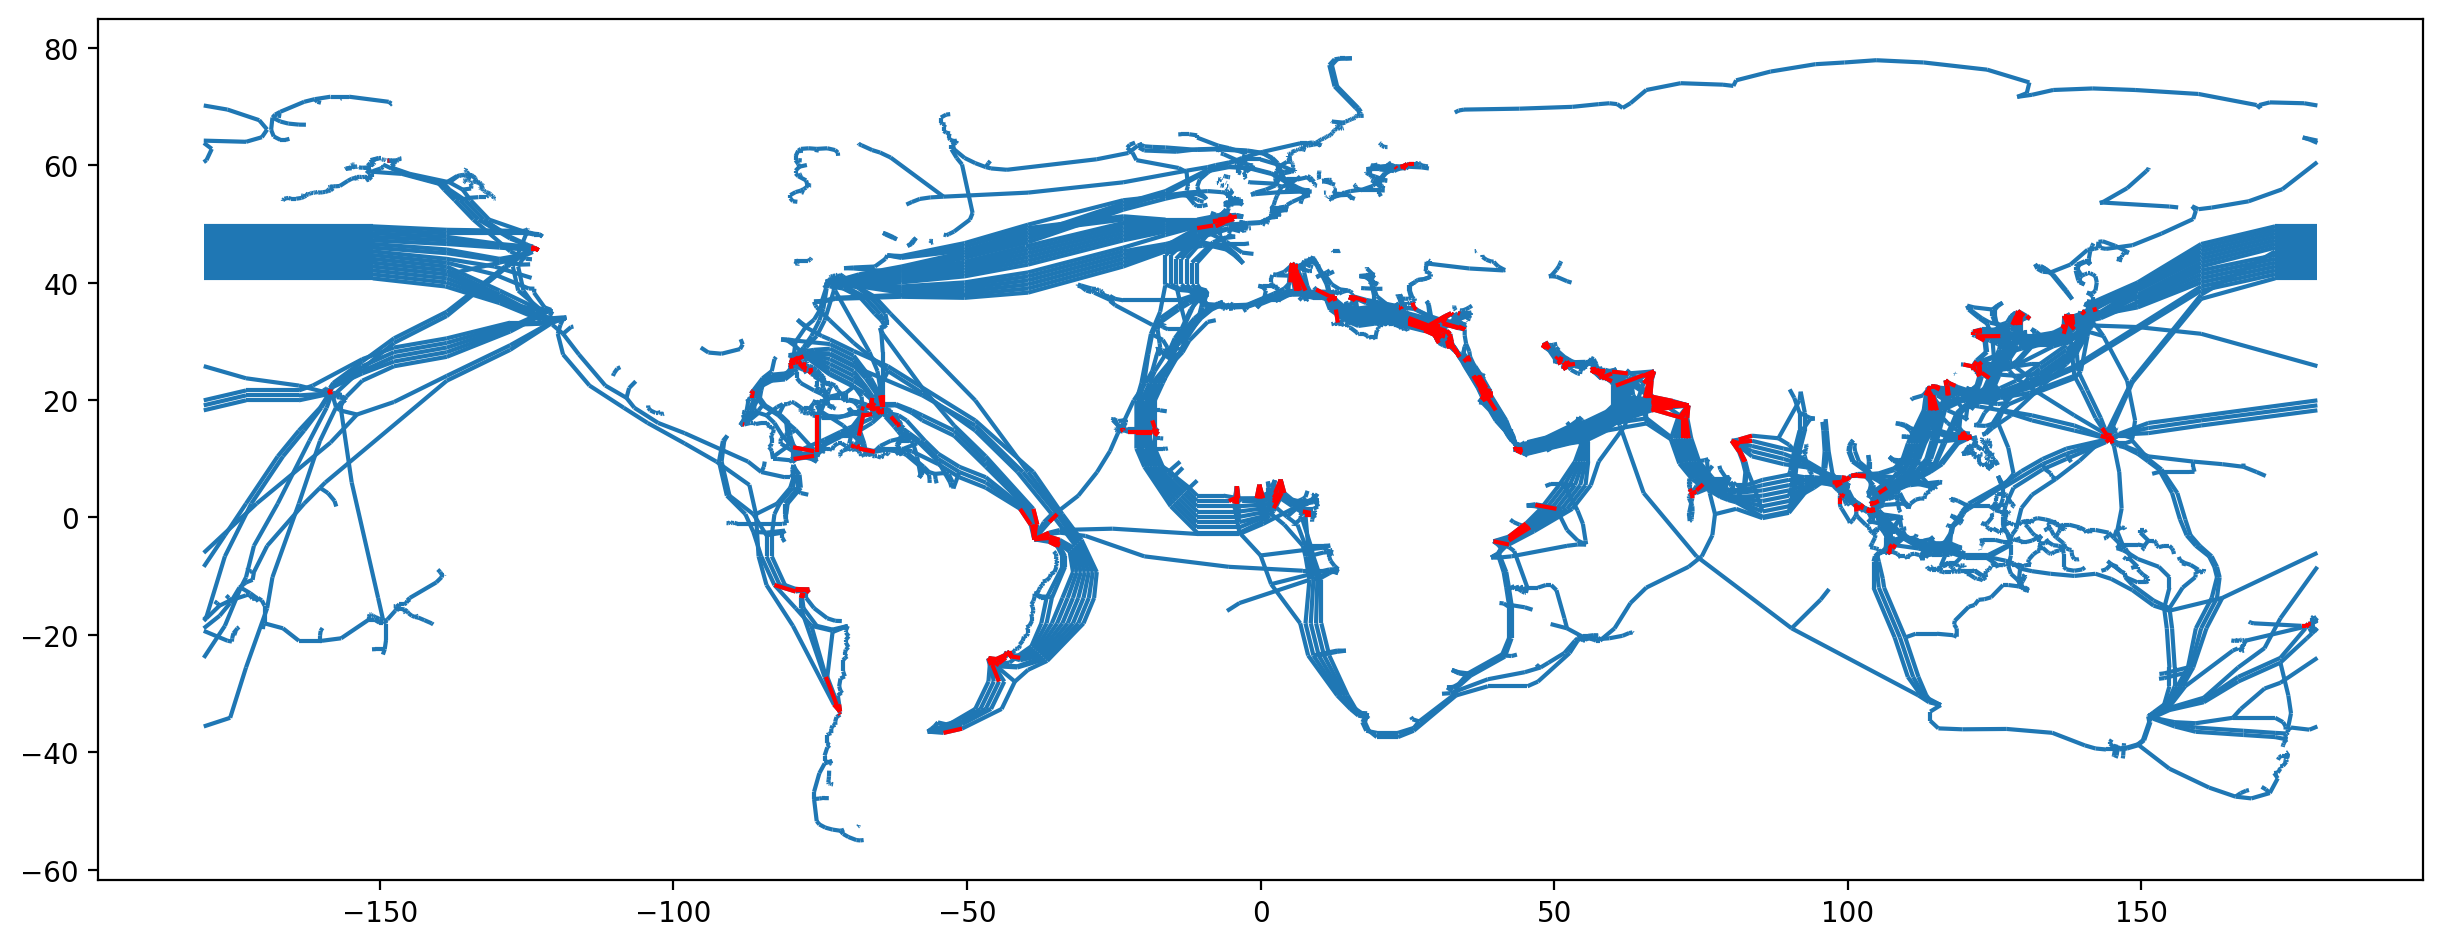

In [27]:
# https://networkx.org/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.assortativity.average_degree_connectivity.html#networkx.algorithms.assortativity.average_degree_connectivity
temp = {}
for key, value in nx.average_neighbor_degree(G).items():
    if value >= 4:
        temp[key] = value
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
gdf.plot(ax=ax)
gdf[gdf['fr_id'].isin(temp.keys()) ].plot(ax = ax, color='red')

In [28]:
# T = nx.minimum_spanning_tree(G, algorithm='kruskal')  # 返回包括最小生成树的图


# path_road = getPath(list (T), gdf)

# fig     = plt.figure(figsize=(15,10),dpi = 200)
# ax      = plt.subplot(111)
# gdf.plot(ax=ax)
# path_road.plot(ax = ax, color='red')

In [29]:
# T = nx.minimum_edge_cut(G)

In [30]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    landingPoint_connection = pd.read_sql("select count(*) as neighborCount, landingPoint_id, landingPoint_name, landingPoint_country, landingPoint_longitude, landingPoint_latitude from landing_points group by landingPoint_id having neighborCount >= 3",con=con)
    landingPoint = pd.read_sql("select * from landing_points",con=con)


landingPoint_connection_gdf = gpd.GeoDataFrame(landingPoint_connection, geometry=gpd.points_from_xy(x=landingPoint_connection['landingPoint_longitude'],y=landingPoint_connection['landingPoint_latitude']))

landingPoint_gdf = gpd.GeoDataFrame(landingPoint, geometry=gpd.points_from_xy(x=landingPoint['landingPoint_longitude'],y=landingPoint['landingPoint_latitude']))
# landingPoint_connection_gdf.plot()


# for x,y,price in zip(scatter_se.lon,scatter_se.lat,scatter_se['实用单价']):
#     hk_map.scatter(x,y,s=price/500,color='#FFEB3B',alpha=.5,ec='k',lw=.1)

In [31]:
# ax = gplt.polyplot(df=nyc_boroughs,
#                    projection=gcrs.AlbersEqualArea())
 
# # 叠加核密度图层
# ax = gplt.kdeplot(df=nyc_collision_factors,
#                   cmap='Reds',
#                   shade=True,
#                   shade_lowest=True,
#                   clip=nyc_boroughs,
#                   ax=ax)
 
# plt.savefig("图6.png", bbox_inches='tight', pad_inches=0, dpi=300)
landingPoint_connection_gdf

,neighborCount,landingPoint_id,landingPoint_name,landingPoint_country,landingPoint_longitude,landingPoint_latitude,geometry
0,6,abidjan-cte-divoire,"Abidjan, Cote D'Ivoire",Cote D'Ivoire,-4.026253,5.323494,POINT (-4.02625 5.32349)
1,6,abu-talat-egypt,"Abu Talat, Egypt",Egypt,29.702495,31.071849,POINT (29.70249 31.07185)
2,6,accra-ghana,"Accra, Ghana",Ghana,-0.200914,5.558502,POINT (-0.20091 5.55850)
3,3,al-faw-iraq,"Al Faw, Iraq",Iraq,48.531780,29.923671,POINT (48.53178 29.92367)
4,4,al-khobar-saudi-arabia,"Al Khobar, Saudi Arabia",Saudi Arabia,50.214262,26.286558,POINT (50.21426 26.28656)
...,...,...,...,...,...,...,...
190,6,willemstad-curaao,"Willemstad, Curacao",Curacao,-68.896605,12.095319,POINT (-68.89661 12.09532)
191,5,yanbu-saudi-arabia,"Yanbu, Saudi Arabia",Saudi Arabia,38.107016,24.070617,POINT (38.10702 24.07062)
192,7,yeroskipos-cyprus,"Yeroskipos, Cyprus",Cyprus,32.466688,34.766628,POINT (32.46669 34.76663)
193,8,zafarana-egypt,"Zafarana, Egypt",Egypt,32.649894,29.116662,POINT (32.64989 29.11666)


In [32]:
world_map = folium.Map()
heatdata = landingPoint[['landingPoint_latitude','landingPoint_longitude']].values.tolist()

HeatMap(heatdata,radius=15).add_to(world_map)



neighborCount=landingPoint_connection_gdf["neighborCount"]
lon=landingPoint_connection_gdf["landingPoint_longitude"]
lat=landingPoint_connection_gdf["landingPoint_latitude"]
num=neighborCount.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(neighborCount[i]),location=[lat[i],lon[i]],color="yellow",fill=True,fill_color="red",fill_opacity=0.7).add_to(world_map)


world_map